In [1]:
import pandas as pd
import networkx as nx
import json 
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
from datetime import datetime
import pickle
import itertools
from collections import Counter
import netrd
import seaborn
import random

## DataFrames

In [2]:
def make_dataframe(h, # hashtag with associated folder (needs to become group of hashtags
                   date1, # lower bound in the format 'yyyy-mm-dd'
                   date2 # upper bound in the format 'yyyy-mm-dd'
                  ):
    
    # this has to become all the tweets about a school 

    lower_date = pd.to_datetime(date1)
    upper_date = pd.to_datetime(date2)

    hashtag = h
    
    path = 'hashtags/' + hashtag
    
    directory = os.listdir(path)
    
    directory = [i for i in directory if i != 'test_json_to_csv.csv']
    
    all_id = []
    all_text = []
    all_times = []
    all_users = []
    all_follower = []
    all_rt_count = []
    all_like_count = []
    all_hashtags = []


    for date in directory:
        with open(path + '/' + date, 'rb') as f:
            for line in f: 
                a = json.loads(line)
                if a['id'] not in all_id:
                    all_id.append(a['id'])
                    all_times.append(a['created_at'])
                    all_users.append(a['user']['screen_name'])
                    all_follower.append(a['user']['followers_count'])
                    all_rt_count.append(a['retweet_count'])
                    all_like_count.append(a['favorite_count'])
                    if a['truncated'] == True:
                        all_text.append(a['extended_tweet']['full_text'])
                    else:
                        all_text.append(a['text'])
                    all_hashtags.append([i['text'].lower() for i in a['entities']['hashtags']])
                    
    all_datetime = [datetime.strptime(i, '%a %b %d %H:%M:%S %z %Y') for i in all_times]
    
    all_tweets = pd.DataFrame(data = {'id': all_id, 'text': all_text, 'created_at': all_times, 
                                  'user': all_users, 'followers': all_follower, 'retweets': all_rt_count, 
                                  'likes': all_like_count, 'datetime': all_datetime,
                                 'hashtags': all_hashtags, 
                                 'pd_datetime': [pd.to_datetime(i) for i in all_times]})
    all_tweets = all_tweets.sort_values('datetime')
    all_tweets = all_tweets.reset_index(drop = True)
    
    window_tweets = all_tweets[(all_tweets['pd_datetime'] > lower_date) & (all_tweets['pd_datetime'] < upper_date)]
    window_tweets = window_tweets.reset_index(drop = True)
    
    return window_tweets

## Cumulative Tweet Volume

In [3]:
# plot the hashtags given a dataframe in the shape of the one output from make_dataframe()
def plot_tags(h, df, percent):
    
    jet = plt.cm.jet
    r = random.random()
    
    window_tweets = df
    
    all_tags = list(itertools.chain.from_iterable(window_tweets.hashtags))
    all_tags = [i for i in all_tags if (i != h)]
    
    tag_freq = Counter(all_tags).most_common()
    
    # currently getting anything more than 1% but this has to be changed
    # going to become the hashtag clusters/communities 

    top_tags = [tag[0] for tag in tag_freq if tag[1] > percent * len(window_tweets)]
    
    tag_vol = {}

    for tag in top_tags:
        counts = []
        times = []
        count = 0
        for t in range(1, len(window_tweets.hashtags)):
            if tag in window_tweets.hashtags[t]:
                count += 1
                counts.append(count)
                times.append((window_tweets.pd_datetime[t] - window_tweets.pd_datetime[0]).total_seconds()/60/60)
        tag_vol[tag] = (counts, times)
        
    plt.figure(figsize = (10, 5))
    for tag in top_tags[:10]:
        plt.plot(tag_vol[tag][1], tag_vol[tag][0], label = tag, alpha = 0.9)
    for tag in top_tags[10:]:
        r = random.random()
        plt.plot(tag_vol[tag][1], tag_vol[tag][0], label = tag, color = jet(r), alpha = 0.9)
    plt.legend(bbox_to_anchor = (1, 0.25, 0.3, 0.7))
    plt.title('%s Co-Occurring Hashtag Growth' % (h.capitalize())) 
    plt.xlabel('Hours Since Event')
    plt.ylabel('Cumulative Tweets')

In [4]:
# plot the hashtags given a dataframe in the shape of the one output from make_dataframe()
def cum_tags(h, df, percent):
    
    window_tweets = df
    
    all_tags = list(itertools.chain.from_iterable(window_tweets.hashtags))
    all_tags = [i for i in all_tags if (i != h)]
    
    tag_freq = Counter(all_tags).most_common()
    
    # currently getting anything more than 1% but this has to be changed
    # going to become the hashtag clusters/communities 

    top_tags = [tag[0] for tag in tag_freq if tag[1] > percent * len(window_tweets)]
    
    tag_vol = {}

    for tag in top_tags:
        counts = []
        times = []
        count = 0
        for t in range(1, len(window_tweets.hashtags)):
            if tag in window_tweets.hashtags[t]:
                count += 1
                counts.append(count)
                times.append((window_tweets.pd_datetime[t] - window_tweets.pd_datetime[0]).total_seconds()/60/60)
            else:
                counts.append(count)
                times.append((window_tweets.pd_datetime[t] - window_tweets.pd_datetime[0]).total_seconds()/60/60)
        tag_vol[tag] = (counts, times)
        
    return tag_vol  

In [5]:
def create_graph(hashtag, # hashtag with associated folder (needs to become group of hashtags)
                   date1, # lower bound in the format 'yyyy-mm-dd'
                   date2, # upper bound in the format 'yyyy-mm-dd'
                percent):  # Percent of total tweets necessary to be in the hashtag shown):
                 
    df = make_dataframe(hashtag, date1, date2)
    plot_tags(hashtag, df, percent)

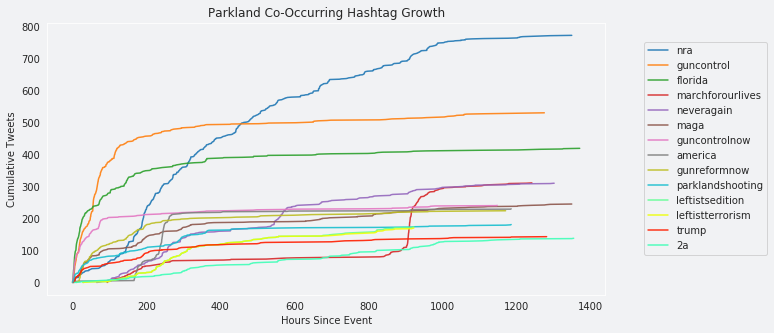

In [105]:
create_graph('parkland','2018-02-13','2018-04-13', 0.01)
plt.savefig('correct_color_cohash.png',facecolor=fig.get_facecolor(), edgecolor='none', 
            bbox_inches = 'tight', dpi=1200)

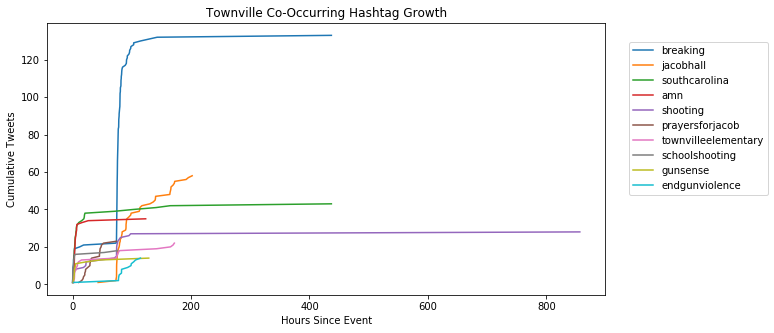

In [534]:
create_graph('townville', '2016-09-26', '2016-11-26', 0.005)

In [ ]:
create_graph('santafestrong', '2018-05-15', '2018-05-25', 0.02)

In [ ]:
create_graph('ifidieinaschoolshooting', '2018-05-15', '2018-06-15', 0.01)

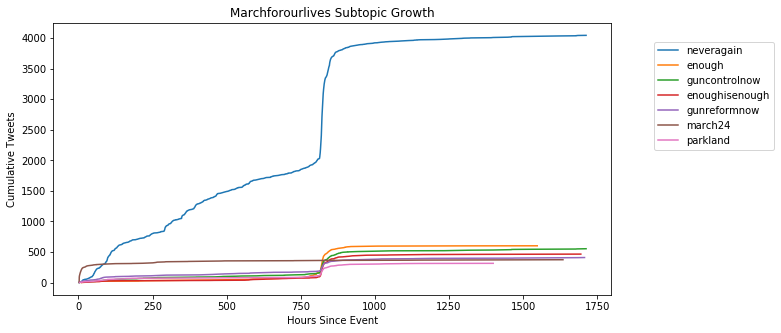

In [123]:
create_graph('marchforourlives', '2018-02-13', '2018-05-01', 0.005)

## Co-Occurrence Networks

In [6]:
# co_occurrence: event -> co-occurrence network 
# function takes hashtags from tweets for the give event dataframe and creates edges between them based on co-occurrence in a tweet
# so that the output is an nx undirected graph

def co_occurrence(hashtag, # hashtag with associated folder (needs to become group of hashtags)
                   date1, # lower bound in the format 'yyyy-mm-dd'
                   date2 # upper bound in the format 'yyyy-mm-dd'
                ):
    all_tweets = make_dataframe(hashtag, date1, date2)

    hashtags = all_tweets.hashtags

    tag_edges = []

    for l in hashtags:
        low = [i.lower() for i in l]
        new_edges = list(itertools.product(*[low, low]))
        tag_edges.append(new_edges)

    tag_edges = list(itertools.chain.from_iterable(tag_edges))

    tag_edges = [t for t in tag_edges if hashtag not in t]

    tag_edges = [t for t in tag_edges if t[0] != t[1]]

    weighted_proxy = list(Counter(tag_edges).most_common())

    weighted_edges = [(w[0][0], w[0][1], w[1]) for w in weighted_proxy]

    G = nx.Graph()
    G.add_weighted_edges_from(weighted_edges)
    
    return G

In [10]:
# create graphs for each 

G = co_occurrence('townville', '2016-09-26', '2016-10-26')
P = co_occurrence('parkland', '2018-02-13','2018-04-13')
B = co_occurrence('sanbernardino', '2015-12-01', '2015-12-22')
S = co_occurrence('santafestrong', '2018-05-15', '2018-05-25')
NP = co_occurrence('northpark', '2017-04-09', '2017-04-30')
AZ = co_occurrence('aztecstrong', '2017-12-06', '2017-12-27')

In [ ]:
# write graphs as gexy files for GEPHI
nx.write_gexf(P, 'parkland_co_occurrence_graph.gexf')
nx.write_gexf(G, 'townville_co_occurrence_graph.gexf')
nx.write_gexf(S, 'santafestrong_co_occurrence.gexf')
nx.write_gexf(S1, 'santafeshooting_co_occurrence.gexf')

In [7]:
hashtags = os.listdir('hashtags')

In [77]:
co_graphs = [G, P, S, NP, AZ]

In [78]:
# calculates and plots network diameter for each co-occurrence graph 

Nd = []
for g in co_graphs:
    gcc = sorted(nx.connected_components(g),key=len, reverse=True)
    try:
        g0 = g.subgraph(gcc[0])
        Nd.append((len(g.nodes()), nx.diameter(g0)))
    except IndexError:
        pass

plt.scatter([i[0] for i in Nd], [i[1] for i in Nd])

## Clusterig Coefficients

In [ ]:
import stats

In [72]:
# calculates and plots clustering coefficient for each graph
ccs = []
for g in co_graphs:
    ccs.append(nx.average_clustering(g))
plt.scatter([len(g.nodes()) for g in co_graphs], ccs)

In [88]:
# calculates and average degree for each graph
k_list = []
for g in co_graphs:
    k = np.mean([n[1] for n in list(g.degree)])
    k_list.append(k)

## Correcting tau

Finding the characterstic times over the course of the Parkland time series which maximize information in the 
Naive Transfer Entropy

In [152]:
taus_short = ['H', '2H', '5H', '10H', '12H', '15H', '24H']

In [154]:
weights_by_frame = []
sum_by_frame = []
graphs = {}
n = 0

arr_split = [10*i for i in range(1, 9)]
ts = np.split(time_series, arr_split, axis =1)


for t in ts:
    weights = {}
    T_tau_short = []
    T_taus_short = {}
    for delta in taus_short:
        time_ser_df = time_ser_df.resample(delta).sum()
        time_ser_list = []
        for tag in top_tags:
            time_ser_list.append(list(time_ser_df[tag]))
        T_taus_short[delta] = np.array(time_ser_list)
        testTE = netrd.reconstruction.NaiveTransferEntropy()
        test = testTE.fit(T_taus_short[delta])
        weights[delta] = [test.edges[i]['weight'] for i in test.edges]
        T_tau_short.append((delta, sum(weights[delta])))
    weights_by_frame.append(weights)
    sum_by_frame.append(T_tau_short)
    n += 1

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/netrd/utilities/threshold.py:42: RuntimeWarning: Setting 'cutoffs' argument is strongly encouraged. Using cutoff range of (-1, 1).
  RuntimeWarning,


In [156]:
best_by_frame = []
for f in sum_by_frame:
    for delt in f:
        if delt[1] == max([i[1] for i in f]):
            best_by_frame.append(delt[0])

In [157]:
best_by_frame

['12H', '24H', '12H', '24H', '24H', '24H', '24H', '24H', '24H']

In [158]:
sum_by_frame

[[('H', 0.003078000335874218),
  ('2H', 0.012446613822111152),
  ('5H', 0.08045206053224357),
  ('10H', 1.95897722680269),
  ('12H', 2.1008137432375347),
  ('15H', 1.17730807118528),
  ('24H', 0.6877438884025266)],
 [('H', 0.0005642997618511662),
  ('2H', 0.0022683498232524066),
  ('5H', 0.014391020652576289),
  ('10H', 0.05905676966238249),
  ('12H', 0.08593759853807395),
  ('15H', 0.09652871637397403),
  ('24H', 1.258616387072444)],
 [('H', 0.00040016676184992037),
  ('2H', 0.0016083175252056062),
  ('5H', 0.0101986354713718),
  ('10H', 0.04181740470843809),
  ('12H', 0.5690542245907122),
  ('15H', 0.04059695341917646),
  ('24H', 0.10715308599089413)],
 [('H', 0.00017246403486907355),
  ('2H', 0.0006920235622833171),
  ('5H', 0.004366387865534366),
  ('10H', 0.017748817262159378),
  ('12H', 0.025725837925032302),
  ('15H', 0.0555652694023262),
  ('24H', 0.14788483216540355)],
 [('H', 0.00023343065461508758),
  ('2H', 0.0009373466168162564),
  ('5H', 0.00592767629855287),
  ('10H', 0.

In [34]:
taus = ['min', '2min', '5min', '10min', '15min', '20min', '30min', '45min', 'H']

In [35]:
T_tau = []
time_serieses = {}
for t in taus:
    time_ser_df = time_ser_df.resample(t).sum()
    time_ser_list = []
    for tag in top_tags:
        time_ser_list.append(list(time_ser_df[tag]))
    time_serieses[t] = np.array(time_ser_list)
    testTE = netrd.reconstruction.NaiveTransferEntropy()
    test = testTE.fit(time_serieses[t])
    weights = [test.edges[i]['weight'] for i in test.edges]
    T_tau.append((t, sum(weights)))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/netrd/utilities/threshold.py:42: RuntimeWarning: Setting 'cutoffs' argument is strongly encouraged. Using cutoff range of (-1, 1).
  RuntimeWarning,


In [36]:
T_tau

[('min', 1.5385833658800008e-07),
 ('2min', 6.154941215495919e-07),
 ('5min', 7.6908917356728e-06),
 ('10min', 3.0778966359609056e-05),
 ('15min', 6.928736305302635e-05),
 ('20min', 0.00012323927449748358),
 ('30min', 0.00027756668097324994),
 ('45min', 0.0006254670650203843),
 ('H', 0.0011136220173506815)]

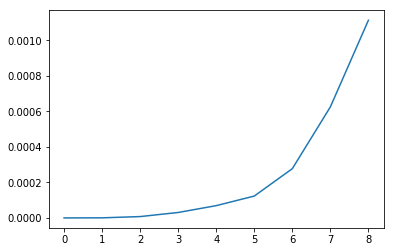

In [37]:
plt.plot(range(len(T_tau)), [t[1] for t in T_tau])

In [19]:
taus_H = ['H', '2H', '5H', '10H', '12H', '15H', '24H', '36H', '48H', '72H', '96H']

In [20]:
T_tau_H = []
T_taus_H = {}
weights = {}
for t in taus_H:
    time_ser_df = time_ser_df.resample(t).sum()
    time_ser_list = []
    for tag in top_tags:
        time_ser_list.append(list(time_ser_df[tag]))
    T_taus_H[t] = np.array(time_ser_list)
    testTE = netrd.reconstruction.NaiveTransferEntropy()
    test = testTE.fit(T_taus_H[t])
    weights[t] = [test.edges[i]['weight'] for i in test.edges]
    T_tau_H.append((t, sum(weights)))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/netrd/utilities/threshold.py:42: RuntimeWarning: Setting 'cutoffs' argument is strongly encouraged. Using cutoff range of (-1, 1).
  RuntimeWarning,


In [21]:
T_tau_H

[('H', 0.0011136220173506815),
 ('2H', 0.004481613612386096),
 ('5H', 0.028533354663956928),
 ('10H', 1.0959835028319056),
 ('12H', 0.8555777831249581),
 ('15H', 0.4052127987818095),
 ('24H', 1.146917566758003),
 ('36H', 2.360740712475348),
 ('48H', 3.602259579506283),
 ('72H', 2.352518695410154),
 ('96H', 5.394375181296873)]

In [18]:
T_tau_short

[('H', 0.0011136220173506815),
 ('2H', 0.004481613612386096),
 ('5H', 0.028533354663956928),
 ('10H', 1.0959835028319056),
 ('12H', 0.8555777831249581),
 ('15H', 0.4052127987818095),
 ('24H', 1.146917566758003)]

## Time Series w Topics

Creating a Time Series and Naive Transfer Entropy plot for topics in the Parkland tweet set

In [18]:
# Creating the tweet dataframe
os.listdir('hashtags')
all_tweets_w = make_dataframe('parkland','2018-02-01','2018-04-01')

['sfstrong',
 'ifidieinaschoolshooting',
 'nowaynra',
 'sanbernardino',
 'demandaplan',
 'parklandstrong',
 'townville',
 'endgunviolence',
 'sanbernadino',
 'gunsensepatriot',
 'parklandstudentsspeak',
 '.DS_Store',
 'iwillmarch',
 'northpark',
 'aztecstrong',
 'nationalschoolwalkout',
 'parklandshooting',
 'neveragain',
 'freemanhighschool',
 'santafestrong',
 'enoughisenough',
 'gunskillpeople',
 'townvilleelementaryschool',
 'gunviolenceawareness',
 'freemanstrong',
 'aztechighschool',
 'momsdemandaction',
 'marjorystonemandouglashighschool',
 'gunviolence',
 'northparkelementaryschool',
 'parkland',
 'stonemanstrong',
 'santafehighschool',
 'marchforourlives',
 'prayforsanbernadino',
 'nra',
 'prayforsanbernardino',
 'marshallcountyhighschool',
 'momsdemand',
 'votegunsense',
 'townvillestrong',
 'aztecschoolshooting',
 'gabeparker',
 'santafeshooting',
 'marjorystonemandouglas',
 'freeman',
 'prayforaztec',
 'guncontrolnow']

In [90]:
import nltk
from nltk.corpus import stopwords
import re, string

In [466]:
stop_words = set(stopwords.words('english'))

In [467]:
# cleaning text and turning each tweet into Bag of Words (BoW) and appending to DF
remove_words = ['aren\'t', 'rt', 'this', 'were', 'time', 'arent', 'yet', 'the']
filter1_text = [[word.lower() for word in tweet.split(' ')] for tweet in list(all_tweets_w.text)]
filter2_text = [[word for word in tweet if word not in stop_words] for tweet in filter1_text]
filter3_text = [[word.strip('') for word in tweet if 'https' not in word and '#park' not in word] for tweet in filter2_text]
filtered_text = [[re.sub(r'\W+', '', word) for word in tweet] for tweet in filter3_text]
final_text = [[word for word in tweet if word not in remove_words] for tweet in filtered_text]
all_tweets_w['topics'] = final_text

In [469]:
# working DF with datetime, hashtags, and and BoW
time_ser_df = pd.DataFrame(data = {'pd_datetime': list(all_tweets_w.pd_datetime),
                                   'hashtags': list(all_tweets_w.hashtags),
                                  'topics': list(all_tweets_w.topics)})

In [470]:
# finding topic frequencies for all tweets in Parkland dataset 
all_topics = list(itertools.chain.from_iterable(all_tweets_w.topics))
all_topics = [h for h in all_topics if h != 'parkland']
topic_freq = Counter(all_topics).most_common()

In [471]:
# top_topics: list
# all topics with frequency > 5% 
p = 0.05
top_topics = [topic[0] for topic in topic_freq if (topic[1] > p * len(all_tweets_w))]
top_topics.remove('')

In [473]:
# append frequency of topic to working DF
for topic in top_topics:
    counts = []
    for i in range(len(time_ser_df.pd_datetime)):
        counts.append(time_ser_df.topics[i].count(topic))
    time_ser_df[topic] = counts

In [474]:
# bin DF to 12H and create a second for 24H
time_ser_df = time_ser_df.set_index('pd_datetime')
time_ser_df = time_ser_df.resample('12H').sum()
time_ser_df_long = time_ser_df.resample('24H').sum()

In [477]:
# Bin tweets as per calculated Tau 

time_split = [10*i for i in range(1, 9)]
time_split = time_ser_df.index[time_split]

short_1 = time_ser_df[:time_split[0]]
short_2 = time_ser_df[time_split[1]:time_split[2]]
long_1 = time_ser_df_long[time_split[0]:time_split[1]]
long_2 = time_ser_df_long[time_split[2]:]

test_ser_df = short_1.append(long_1).append(short_1).append(long_2)

DatetimeIndex(['2018-02-12 12:00:00', '2018-02-17 12:00:00',
               '2018-02-22 12:00:00', '2018-02-27 12:00:00',
               '2018-03-04 12:00:00', '2018-03-09 12:00:00',
               '2018-03-14 12:00:00', '2018-03-19 12:00:00'],
              dtype='datetime64[ns]', name='pd_datetime', freq=None)

In [480]:
time_ser_df = test_ser_df

In [481]:
time_ser_list = []

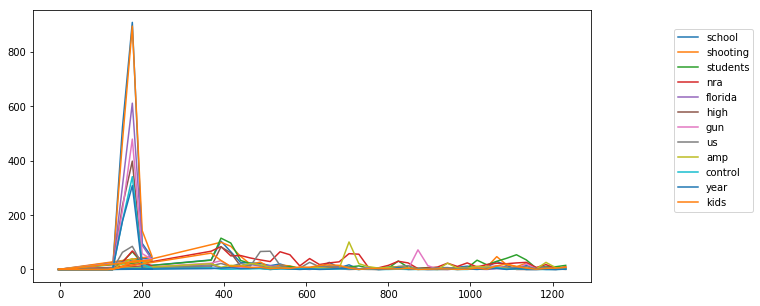

In [482]:
# output time series as np.array()
time_since = [(t-all_tweets_w.pd_datetime[0]).total_seconds()/(60**2) for t in time_ser_df.index]
plt.figure(figsize = (10,5))
for topic in top_topics:
    time_ser_list.append(list(time_ser_df[topic]))
    plt.plot(time_since, time_ser_df[topic], label = topic)
plt.legend(bbox_to_anchor = (1, 0.25, 0.3, 0.7))

In [483]:
time_series = np.array(time_ser_list)

### Topic Naive Transfer Entropy 

In [485]:
STE = netrd.reconstruction.NaiveTransferEntropy()

In [489]:
# Split arrays as per Tau
arr_split = [len(short_1), len(short_1)+len(long_1), 
             len(short_1)+len(short_2)+len(long_1), 
            len(short_1)+len(short_2)+len(long_1) + 5,
            len(short_1)+len(short_2)+len(long_1) + 10,
            len(short_1)+len(short_2)+len(long_1) + 15,
            len(short_1)+len(short_2)+len(long_1) + 20,
            len(short_1)+len(short_2)+len(long_1) + 25]

In [490]:
# ts: time_series DF split as per arr_split
ts = np.split(time_series, arr_split, axis =1)

In [500]:
# Run NTE for each time block to get NTE weights and create NTE graphs 

weights = {}
graphs = {}
n = 0
for t in ts:
    STE = netrd.reconstruction.NaiveTransferEntropy()
    s = STE.fit(t)
    weights[n] = [(i, s.edges[i]['weight']) for i in s.edges]
    graphs[n] = s
    n += 1
    

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/netrd/utilities/threshold.py:42: RuntimeWarning: Setting 'cutoffs' argument is strongly encouraged. Using cutoff range of (-1, 1).
  RuntimeWarning,


In [501]:
for g in graphs:
    a = dict(graphs[g].edges)
    TS_0 = []
    for (n, p) in a:
        try:
            TS_0.append(((n,p),a[(n,p)]['weight'] - a[(p,n)]['weight']))
        except KeyError: 
            TS_0.append(((n,p), a[n,p]['weight']))
    for i in TS_0:
        a[i[0]]['norm_weight'] = i[1]

In [502]:
dict(graphs[0].edges)

{}

In [494]:
heat = []
for t in graphs:
    h = [graphs[t].in_degree(n, weight = 'norm_weight') for n in graphs[t]]
    heat.append(h)

AttributeError: 'Graph' object has no attribute 'in_degree'

In [495]:
max_heat = max(list(itertools.chain.from_iterable(heat)))

ValueError: max() arg is an empty sequence

In [110]:
heat = [[n/max_heat for n in h] for h in heat]

In [111]:
heat_np = np.array(heat)
heat_np = np.transpose(heat_np)

In [119]:
label_dates = list(time_ser_df.index[_split].strftime('%Y-%m-%d'))

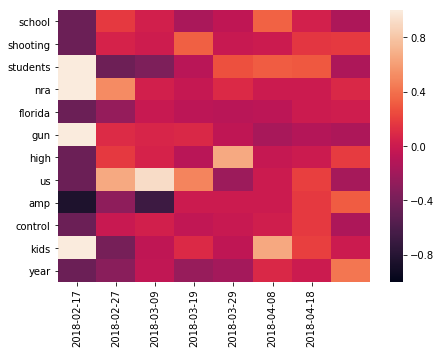

In [124]:
plt.figure(figsize = (7, 5))
seaborn.heatmap(heat_np, xticklabels = label_dates, yticklabels = top_topics)
plt.ylabel('Topic')
plt.xlabel('Date')

## Time Series w Hashtags

Same as NTE for topics, but for hashtags

In [6]:
all_tweets_short = make_dataframe('parkland','2018-02-13','2018-04-01')

In [7]:
all_tags = list(itertools.chain.from_iterable(all_tweets_short.hashtags))
all_tags = [h for h in all_tags if h != 'parkland']
tag_freq = Counter(all_tags).most_common()

In [8]:
p = 0.01
top_tags = [tag[0] for tag in tag_freq if tag[1] > p * len(all_tweets_short)]

In [9]:
time_ser_df = pd.DataFrame(data = {'pd_datetime': list(all_tweets_short.pd_datetime),
                                   'hashtags': list(all_tweets_short.hashtags),
                                  'topics': list(all_tweets_short.hashtags)})

In [10]:
for tag in top_tags:
    counts = []
    for i in range(len(time_ser_df.pd_datetime)):
        counts.append(time_ser_df.hashtags[i].count(tag))
    time_ser_df[tag] = counts

In [11]:
time_ser_df = time_ser_df.set_index('pd_datetime')

In [12]:
time_ser_df = time_ser_df.resample('12H').sum()

In [13]:
time_ser_df_long = time_ser_df.resample('24H').sum()

In [14]:
time_split = [10*i for i in range(1, 9)]
time_split = time_ser_df.index[time_split]
time_split

DatetimeIndex(['2018-02-19 12:00:00', '2018-02-24 12:00:00',
               '2018-03-01 12:00:00', '2018-03-06 12:00:00',
               '2018-03-11 12:00:00', '2018-03-16 12:00:00',
               '2018-03-21 12:00:00', '2018-03-26 12:00:00'],
              dtype='datetime64[ns]', name='pd_datetime', freq=None)

In [15]:
short_1 = time_ser_df[:time_split[0]]
short_2 = time_ser_df[time_split[1]:time_split[2]]
long_1 = time_ser_df_long[time_split[0]:time_split[1]]
long_2 = time_ser_df_long[time_split[2]:]

In [23]:
test_ser_df = short_1.append(long_1).append(short_2).append(long_2)

In [24]:
len(test_ser_df)

57

In [59]:
time_ser_df = test_ser_df

In [60]:
time_ser_combined = []

In [61]:
time_ser_list = []

In [62]:
test_ser_df

,nra,guncontrol,florida,marchforourlives,neveragain,guncontrolnow,maga,america,gunreformnow,parklandshooting,leftistsedition,leftistterrorism,trump,2a
pd_datetime,,,,,,,,,,,,,,
2018-02-14 12:00:00,6,16,48,0,0,40,1,1,0,8,0,0,1,0
2018-02-15 00:00:00,10,80,93,0,0,53,22,4,3,23,0,0,21,1
2018-02-15 12:00:00,15,63,60,0,0,34,25,0,43,22,0,0,18,3
2018-02-16 00:00:00,6,18,22,0,0,16,18,0,22,8,2,2,6,0
2018-02-16 12:00:00,6,42,8,0,0,17,17,0,21,10,1,1,5,1
2018-02-17 00:00:00,1,66,9,0,0,6,1,0,10,4,0,0,0,0
2018-02-17 12:00:00,4,58,19,0,2,26,11,0,11,4,0,0,0,1
2018-02-18 00:00:00,6,20,13,0,2,8,7,1,6,1,0,0,7,1
2018-02-18 12:00:00,11,16,8,4,4,4,4,0,6,3,2,2,3,2


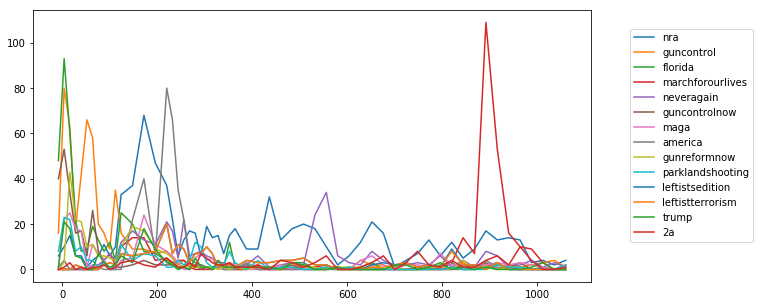

In [63]:
# output time series as np.array()
time_since = [(t-all_tweets_short.pd_datetime[0]).total_seconds()/(60**2) for t in time_ser_df.index]
plt.figure(figsize = (10,5))
for tag in top_tags:
    time_ser_list.append(list(time_ser_df[tag]))
    plt.plot(time_since, time_ser_df[tag], label = tag)
plt.legend(bbox_to_anchor = (1, 0.25, 0.3, 0.7))

In [64]:
time_series = np.array(time_ser_list)

In [65]:
len(time_series[0])

57

In [66]:
arr_split = [len(short_1), len(short_1)+len(long_1), 
             len(short_1)+len(short_2)+len(long_1), 
            len(short_1)+len(short_2)+len(long_1) + 5,
            len(short_1)+len(short_2)+len(long_1) + 10,
            len(short_1)+len(short_2)+len(long_1) + 15,
            len(short_1)+len(short_2)+len(long_1) + 20,
            len(short_1)+len(short_2)+len(long_1) + 25]

In [67]:
ts = np.split(time_series, arr_split, axis =1)

In [68]:
ts

[array([[ 6, 10, 15,  6,  6,  1,  4,  6, 11,  6, 10],
        [16, 80, 63, 18, 42, 66, 58, 20, 16,  9, 35],
        [48, 93, 60, 22,  8,  9, 19, 13,  8, 12,  4],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  4,  7,  2],
        [ 0,  0,  0,  0,  0,  0,  2,  2,  4,  7,  4],
        [40, 53, 34, 16, 17,  6, 26,  8,  4,  0,  1],
        [ 1, 22, 25, 18, 17,  1, 11,  7,  4,  0,  0],
        [ 1,  4,  0,  0,  0,  0,  0,  1,  0,  0,  0],
        [ 0,  3, 43, 22, 21, 10, 11,  6,  6,  5,  4],
        [ 8, 23, 22,  8, 10,  4,  4,  1,  3,  0,  2],
        [ 0,  0,  0,  2,  1,  0,  0,  0,  2,  3,  2],
        [ 0,  0,  0,  2,  1,  0,  0,  0,  2,  3,  2],
        [ 1, 21, 18,  6,  5,  0,  0,  7,  3,  1,  2],
        [ 0,  1,  3,  0,  1,  0,  1,  1,  2,  0,  1]]),
 array([[33, 37, 68, 47, 37],
        [16,  9,  9,  7,  8],
        [25, 20,  8,  7,  4],
        [10, 14, 14,  4,  5],
        [12, 17, 13, 11, 21],
        [ 1,  2,  4,  2,  2],
        [ 4,  5, 24, 11,  8],
        [ 0, 22, 40,  6, 80],
  

In [69]:
weights = {}
graphs = {}
n = 0
for t in ts:
    STE = netrd.reconstruction.NaiveTransferEntropy()
    s = STE.fit(t)
    weights[n] = [(i, s.edges[i]['weight']) for i in s.edges]
    graphs[n] = s
    n += 1

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/netrd/utilities/threshold.py:42: RuntimeWarning: Setting 'cutoffs' argument is strongly encouraged. Using cutoff range of (-1, 1).
  RuntimeWarning,


In [71]:
for g in graphs:
    a = dict(graphs[g].edges)
    TS_0 = []
    for (n, p) in a:
        try:
            TS_0.append(((n,p),a[(n,p)]['weight'] - a[(p,n)]['weight']))
        except KeyError: 
            TS_0.append(((n,p), a[n,p]['weight']))
    for i in TS_0:
        a[i[0]]['norm_weight'] = i[1]

In [72]:
heat = []
for t in graphs:
    h = [graphs[t].in_degree(n, weight = 'norm_weight') for n in graphs[t]]
    heat.append(h)

In [73]:
max_heat = max(list(itertools.chain.from_iterable(heat)))

In [74]:
heat = [[n/max_heat for n in h] for h in heat]

In [75]:
heat_np = np.array(heat)
heat_np = np.transpose(heat_np)

In [76]:
label_dates = list(time_ser_df.index[arr_split].strftime('%Y-%m-%d'))

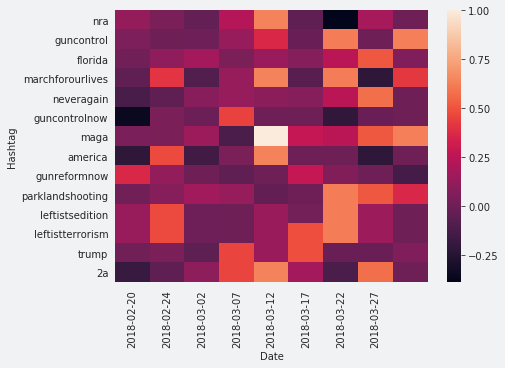

In [106]:
fig = plt.figure(figsize = (7, 5))
seaborn.set_style({'axes.facecolor': '#f1f2f4','figure.facecolor': '#f1f2f4'})
seaborn.heatmap(heat_np, xticklabels = label_dates, yticklabels = top_tags)
plt.ylabel('Hashtag')
plt.xlabel('Date')
plt.savefig('corrected_STE_correct_color.png', facecolor=fig.get_facecolor(), edgecolor='none', 
            bbox_inches = 'tight', dpi=1200)

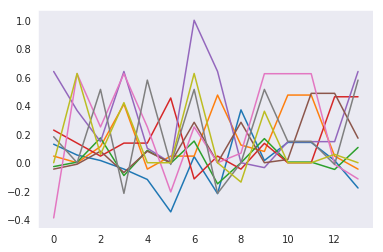

In [82]:
plt.plot(heat_np)

In [87]:
time_series_48 = np.array(time_ser_list)

## 2nd Derivative

In [7]:
park = make_dataframe('parkland','2018-02-13','2018-04-13')
park_cum = cum_tags('parkland',park, 0.01)

In [8]:
park_cum['nra'] == park_cum['nra']

True

In [9]:
len(park_cum['nra'][0])

11910

In [10]:
nra_cum_df = pd.DataFrame(data = {'nra_time': park_cum['nra'][0], 'nra': park_cum['nra'][1]})

In [11]:
gun_cum_df = pd.DataFrame(data = {'gun_time': park_cum['guncontrol'][0], 'gun': park_cum['guncontrol'][1]})

In [12]:
nra_cum_df = nra_cum_df.set_index('nra_time')

In [13]:
gun_cum_df = gun_cum_df.set_index('gun_time')

In [24]:
park_cum['guncontrol'][0][8392]

488

In [43]:
gun_first = np.gradient(park_cum['guncontrol'][0], 0.001)
gun_second = np.gradient(gun_first, 0.001)

In [44]:
gun_first

array([0., 0., 0., ..., 0., 0., 0.])

In [45]:
nra_first = np.gradient(park_cum['nra'][0],0.001)
nra_second = np.gradient(nra_first,0.001)

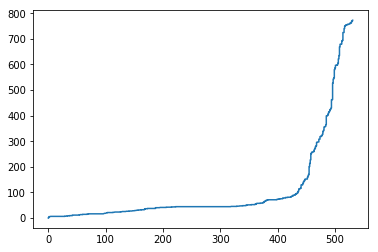

In [46]:
plt.plot(park_cum['guncontrol'][0], park_cum['nra'][0])

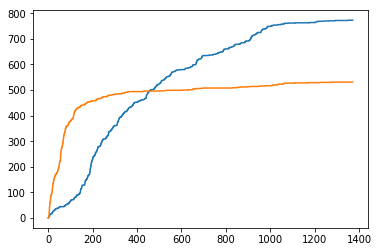

In [47]:
plt.plot(park_cum['nra'][1], park_cum['nra'][0])
plt.plot(park_cum['guncontrol'][1], park_cum['guncontrol'][0])

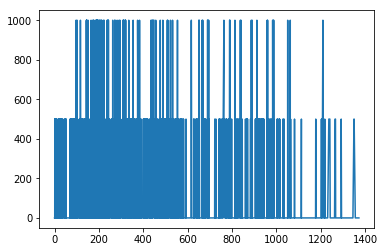

In [48]:
plt.plot(park_cum['nra'][1], nra_first)

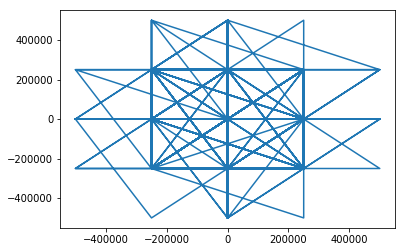

In [49]:
plt.plot(gun_second, nra_second)

In [52]:
d_gun = [(park_cum['guncontrol'][0][i] - park_cum['guncontrol'][0][i-10]/10) for i in 
         range(10, len(park_cum['guncontrol'][0]))]
d_nra = [(park_cum['nra'][0][i] - park_cum['nra'][0][i-10]/10) for i in 
         range(10, len(park_cum['nra'][0]))]

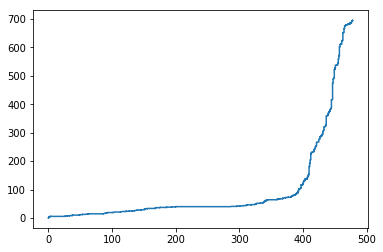

In [53]:
plt.plot(d_gun, d_nra)